# Oil Price Seasonality and Forecasting                                                 
This notebook investigates seasonality in various energy time series. The main objective is to determine whether their are strong trends and seasonality, the seasonality and trends can be predicted, and their relationship with WTI crude oil prices. Data was downloaded from FRED (Federal Reserve Economic Data) https://fred.stlouisfed.org/

The primary methods used in this experiment are:
- Multiplicative seasonal decomposition
- Linear and non-linear regression
- Multiple regression
- ARIMA

The end of this notebook includes a conclusion of findings.

In [18]:
# File imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Package settings
plt.style.use('ggplot')

In [19]:
# Data name mapping (filename, column name)
# Data was downloaded from FRED (Federal Reserve Economic Data): https://fred.stlouisfed.org/
file_names = {
    'data/energy_data/All_Employees_Oil_Gas_Extraction.csv': 'employees',
    'data/energy_data/City_Average_Price_Per_kWH.csv': 'city_average',
    'data/energy_data/Industrial_Production_Utilities_Electric_Gas.csv': 'production',
    'data/energy_data/Manufacturer_New_Orders_Lighting_Equipment.csv': 'orders_lighting',
    'data/energy_data/Manufacturer_New_Orders_Mining_Oil_Gas.csv': 'orders_mining_oil_gas',
    'data/energy_data/WTI_Oil_Prices.csv' : 'oil_price'
}

# Read and combine all files using list comprehension and concat
data = pd.concat([
    pd.read_csv(f).rename(columns={
        'observation_date' : 'observation_date', # Keep the same date column
        f : file_names[f]                        # Rename the column
    }).set_index('observation_date')             # Set the date column as index
    for f in file_names.keys()
], axis=1)

# Clean and adjust the data
data = data.astype(float)
data.index = pd.to_datetime(data.index)
data.drop(data.index[-1], inplace=True)

To start, a sequence of plots was generated for exploratory data analysis.
1. Time series plots of each variable
2. Frequency distribution of each variable
3. Autocorrelation plots
3. Partial autocorrelation plots
4. Scatterplot matrix of each varable
5. Correlation matrix of each variable

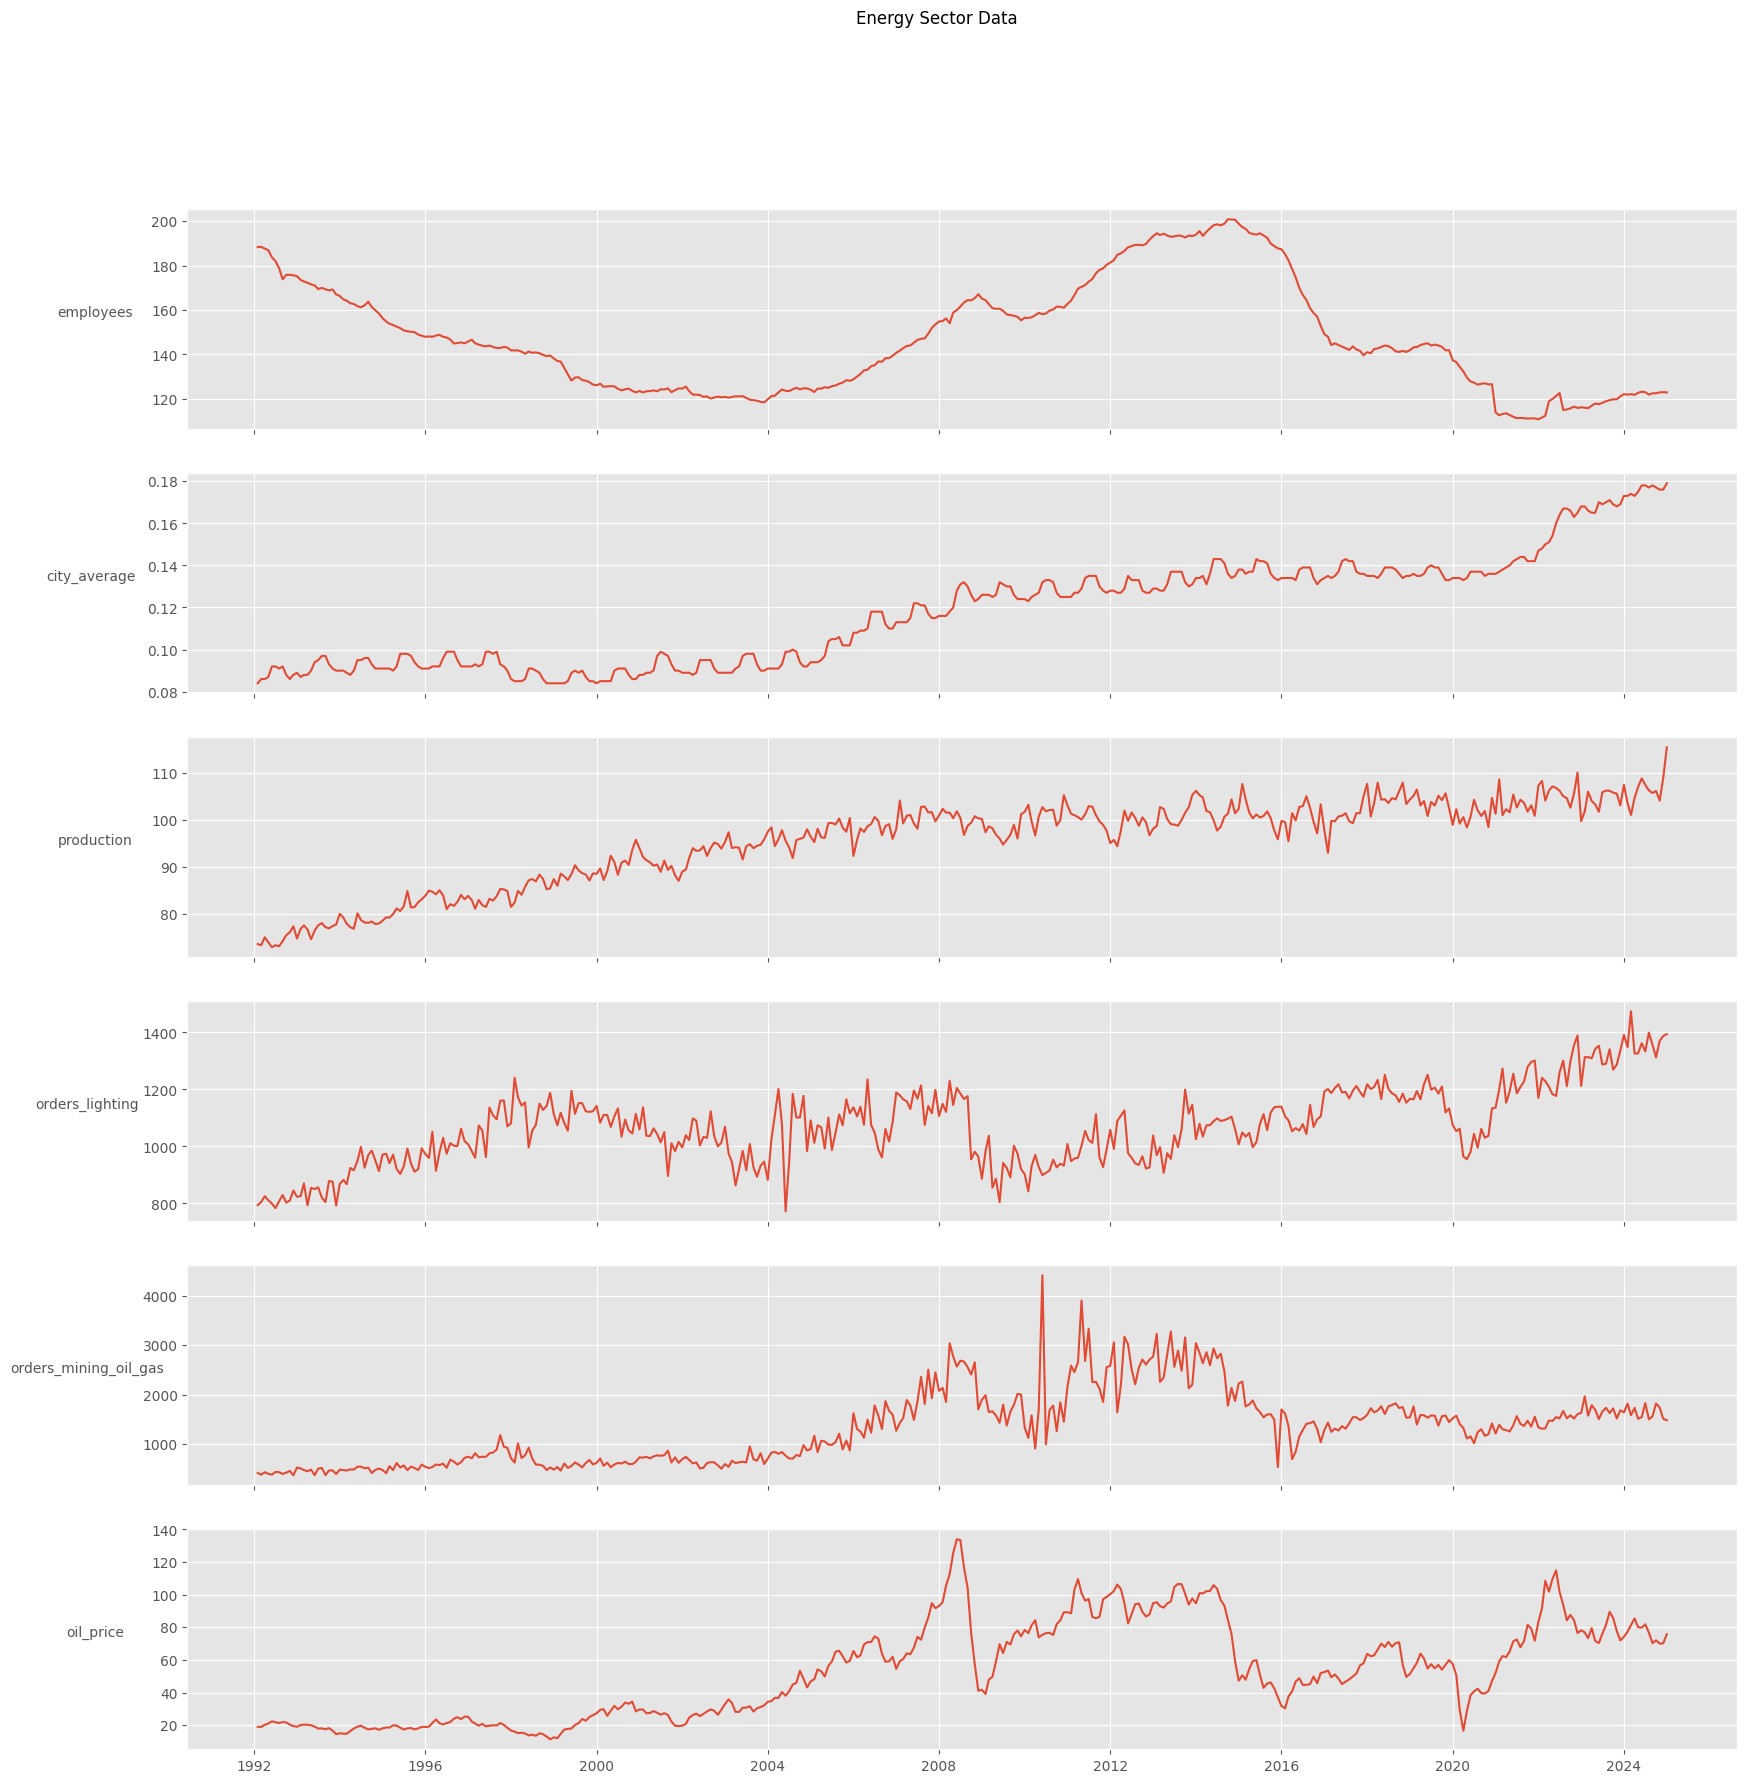

In [20]:
# Data Visualization ==================================================
# Time series plots
N_ROWS, N_COLS = 6, 1
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(20, 20), sharex=True)
fig.suptitle('Energy Sector Data')

idx = 0
for k, v in file_names.items():
    axes[idx].plot(data[v])
    axes[idx].set_ylabel(v, rotation=0, fontsize=10, labelpad=40)
    idx += 1
plt.show()

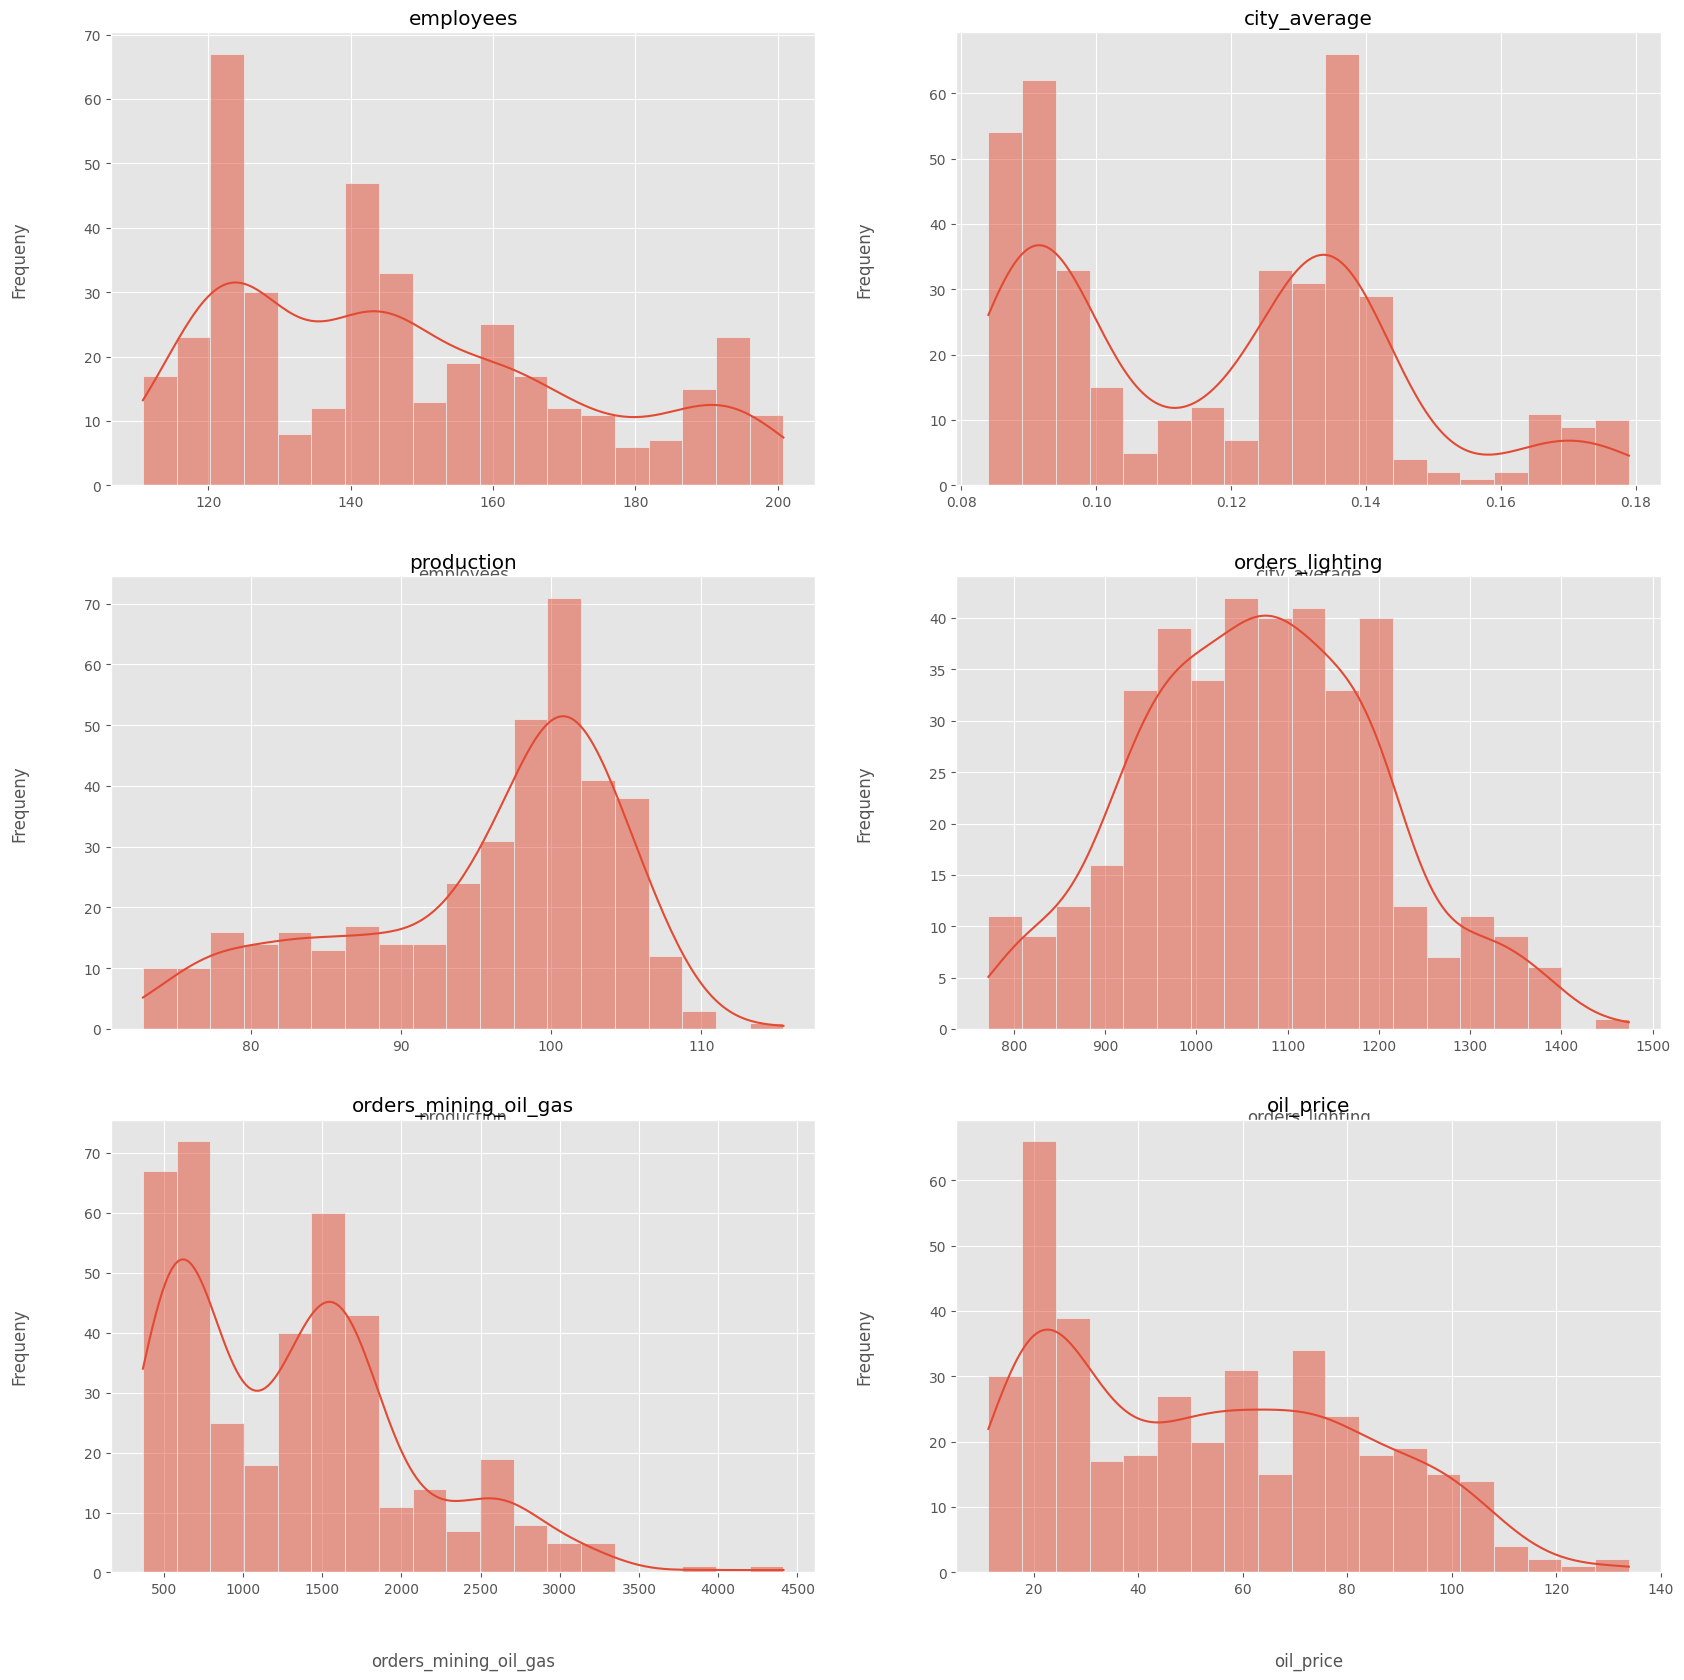

In [21]:
# Distribution plots
N_ROWS, N_COLS, N_BINS = 3, 2, int(math.sqrt(len(data)))
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(20, 20))

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    sns.histplot(data[v], bins=N_BINS, kde=True, ax=axes[r_idx][c_idx])
    axes[r_idx][c_idx].set_title(v)
    axes[r_idx][c_idx].set_xlabel(v, labelpad=40)
    axes[r_idx][c_idx].set_ylabel('Frequeny', labelpad=40)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

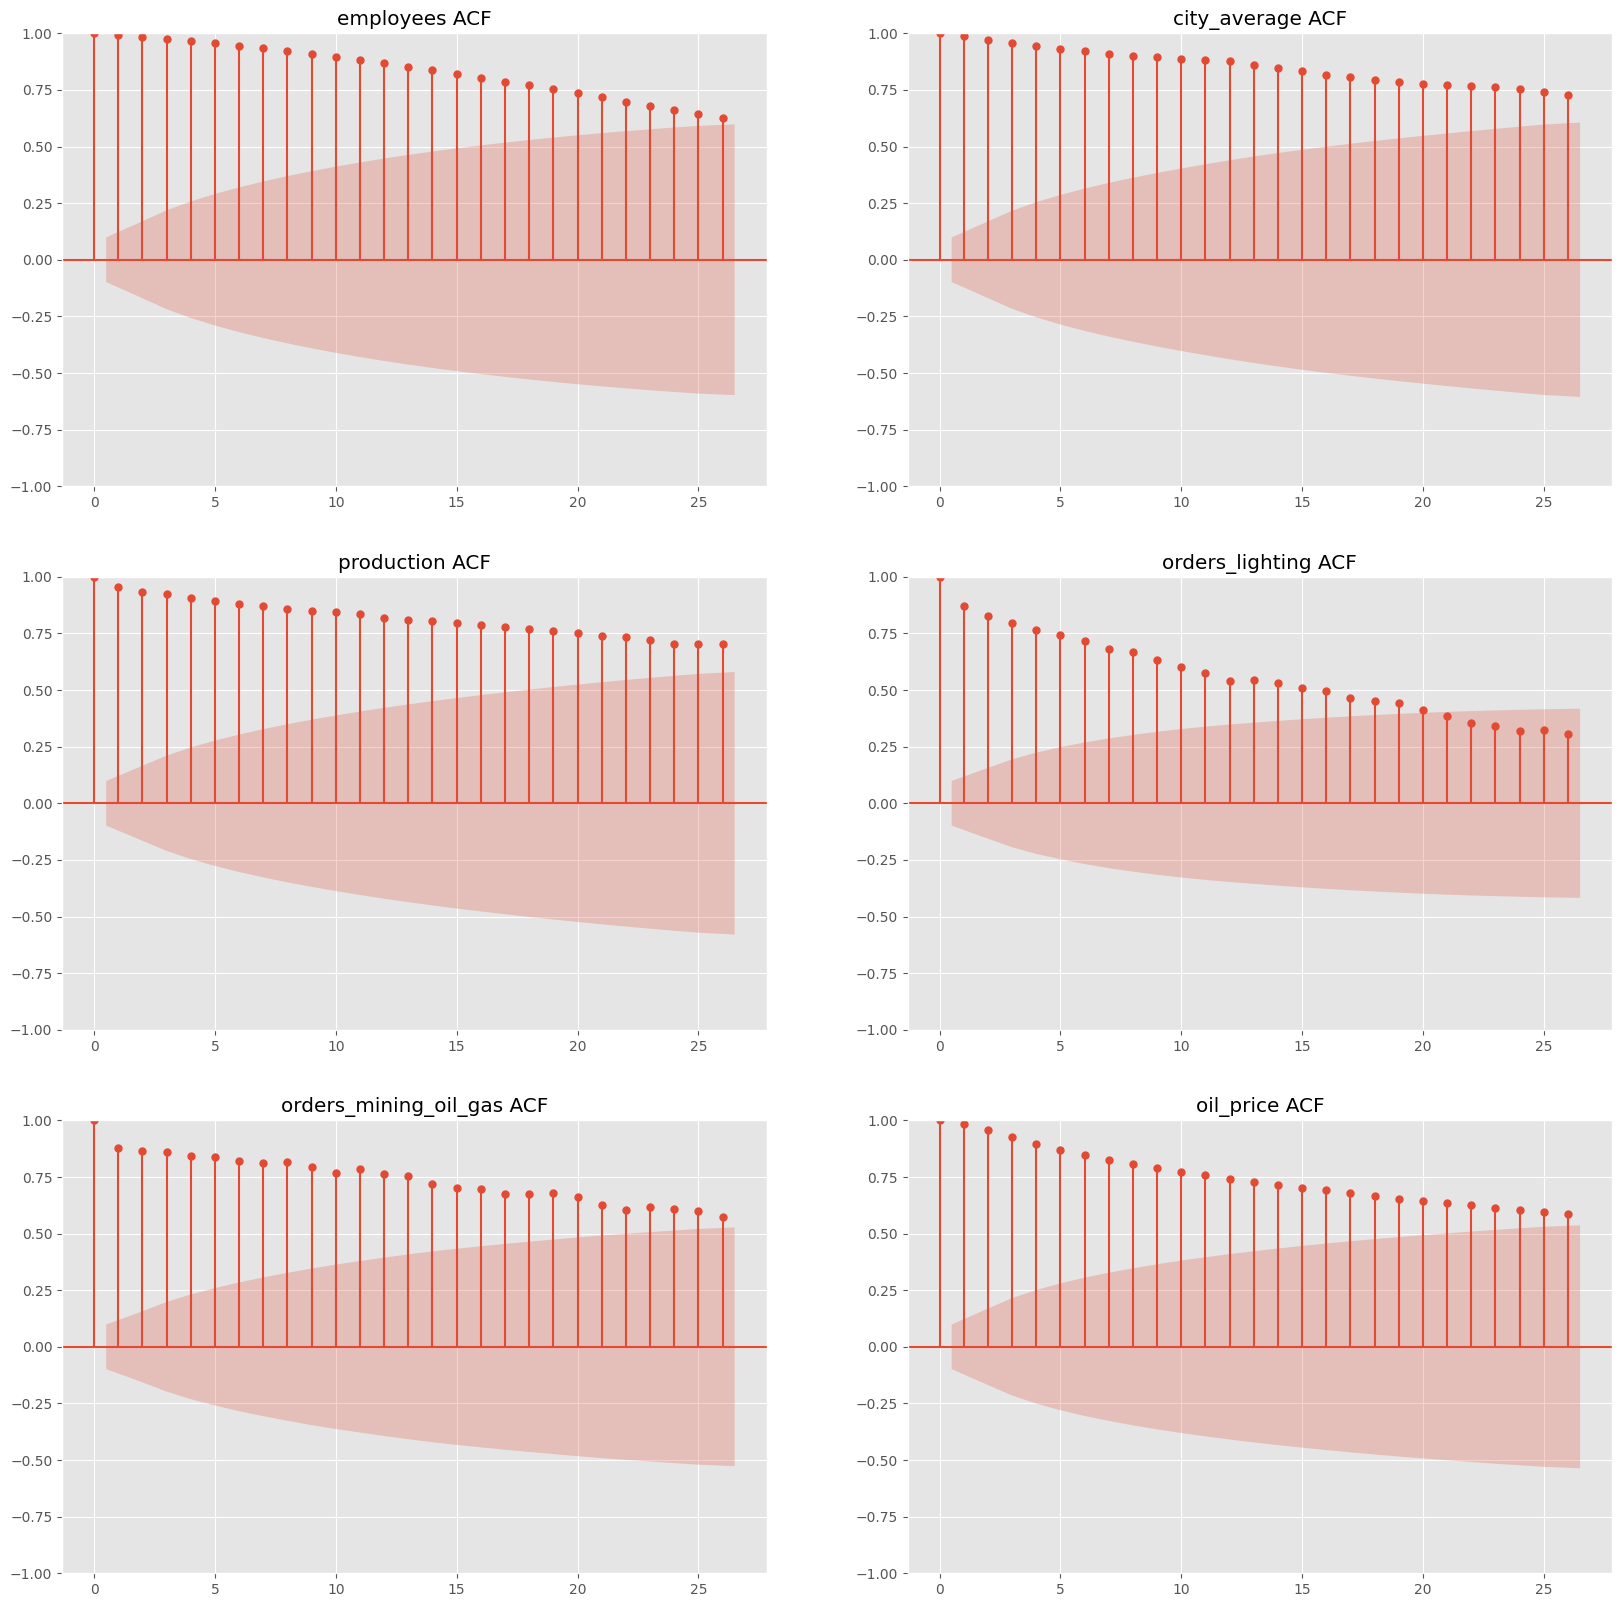

In [22]:
# Autocorrelation plots
N_ROWS, N_COLS = 3, 2
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS)

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    plot_acf(data[v], ax=axes[r_idx][c_idx], title=f"{v} ACF")
    axes[r_idx][c_idx].figure.set_size_inches(20, 20)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

ACF Plot Discussion:<br>
From the ACF plots, we can see that each variable has a gradual decline in autocorrelation as the number of lags increase. This indicates that the time series variables are non-stationary an exhibit a trend. In the orders_lighting and orders_mining_oil _gas ACF plots, there is an indication of some seasonality in addition to the trend. 

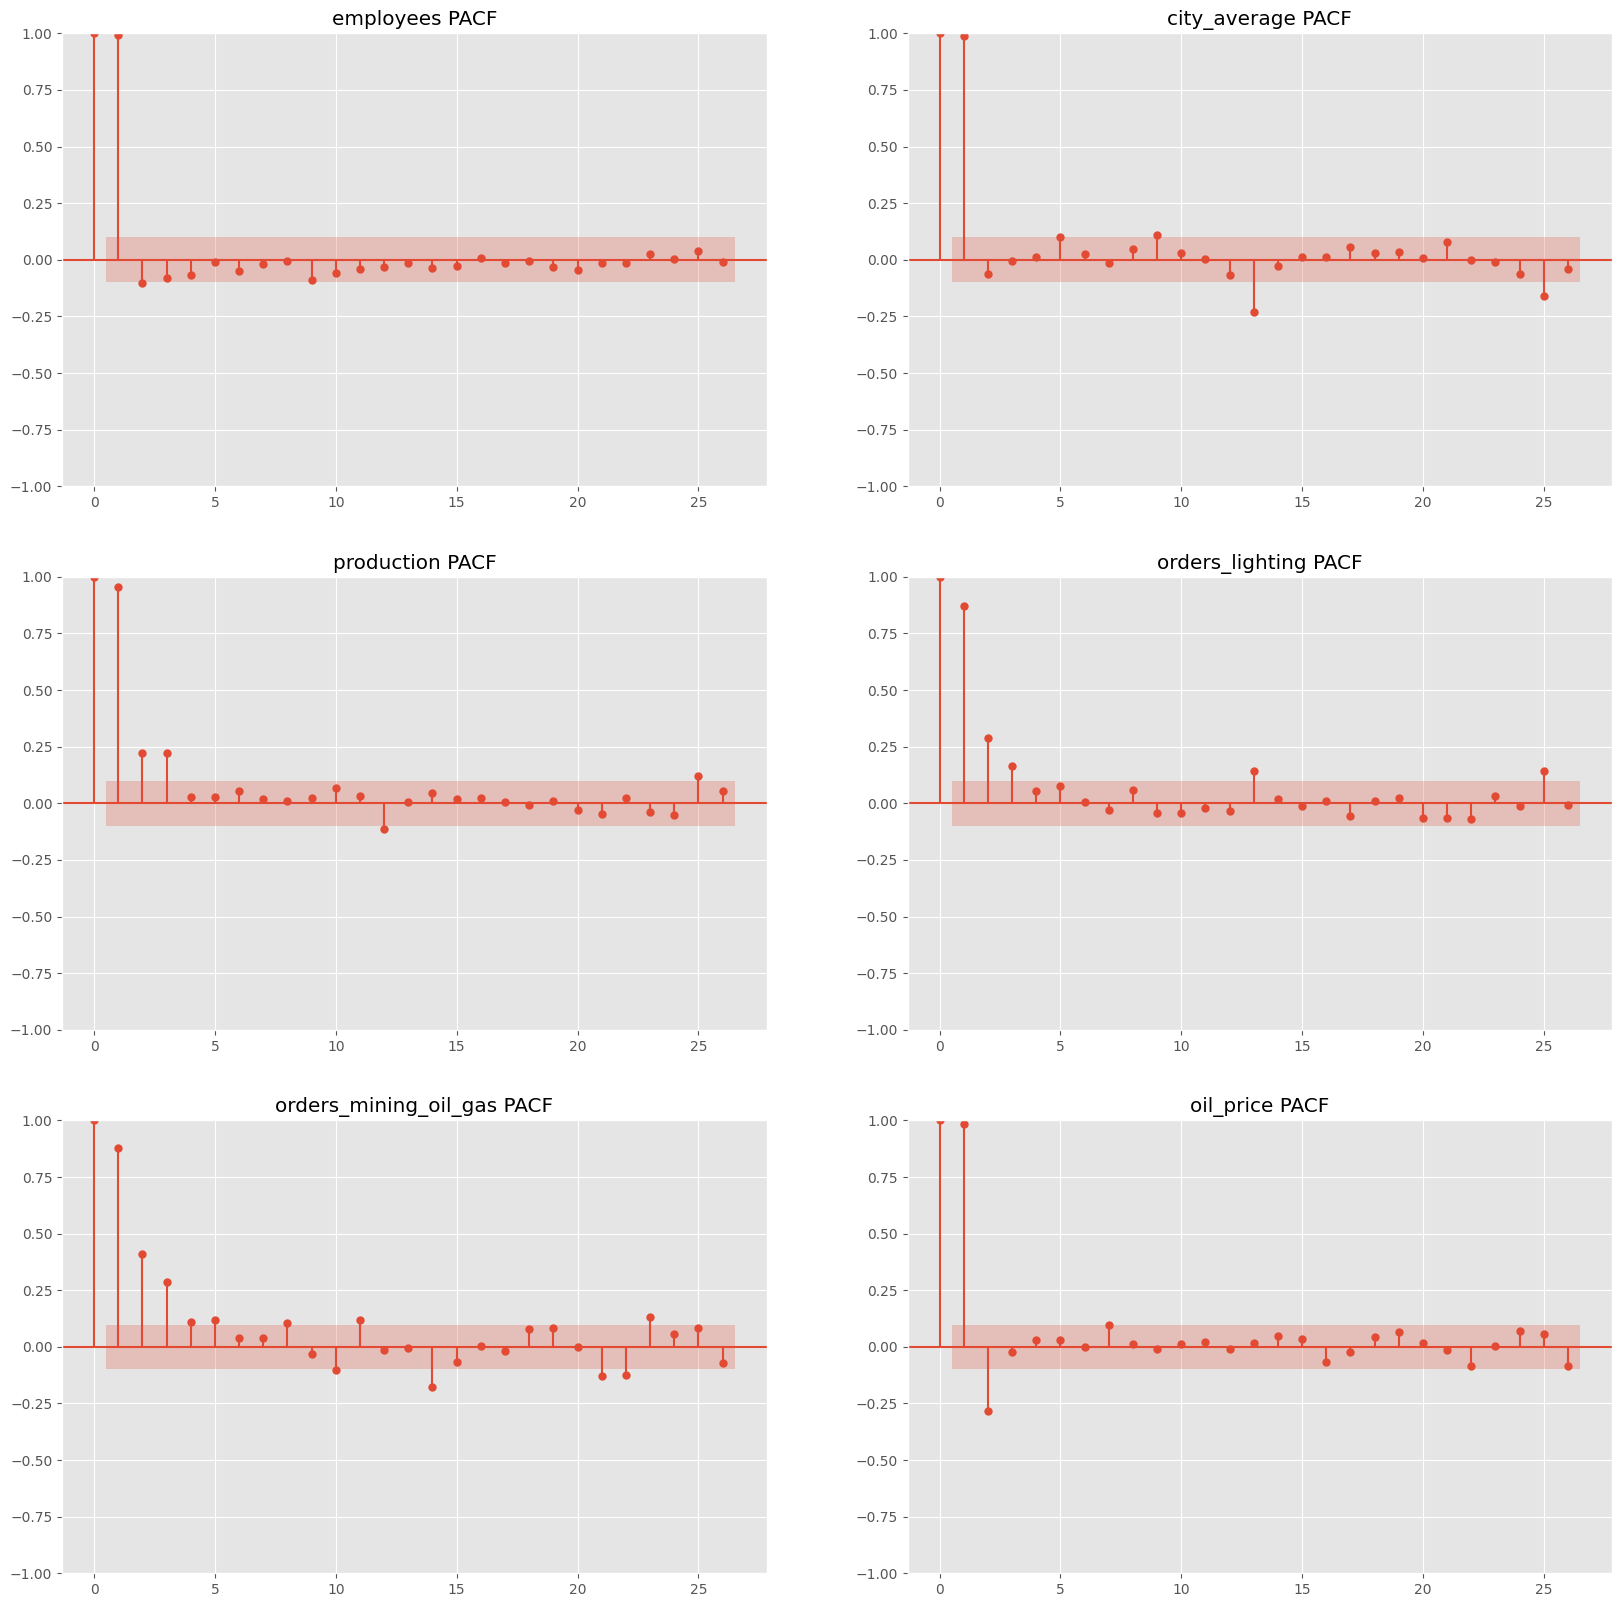

In [23]:
# Partial autocorrelation plots
N_ROWS, N_COLS = 3, 2
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS)

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    plot_pacf(data[v], ax=axes[r_idx][c_idx], title=f"{v} PACF")
    axes[r_idx][c_idx].figure.set_size_inches(20, 20)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

Partial ACF Plot Discussion:
Given the partial ACF plots, we can determine the order of autoregressive models that will be used later in this experiment.
- employees: 1
- city_average: 1 
- production: 3
- orders_lighting: 3
- orders_mining_oil_gas: 5
- oil_price: 2

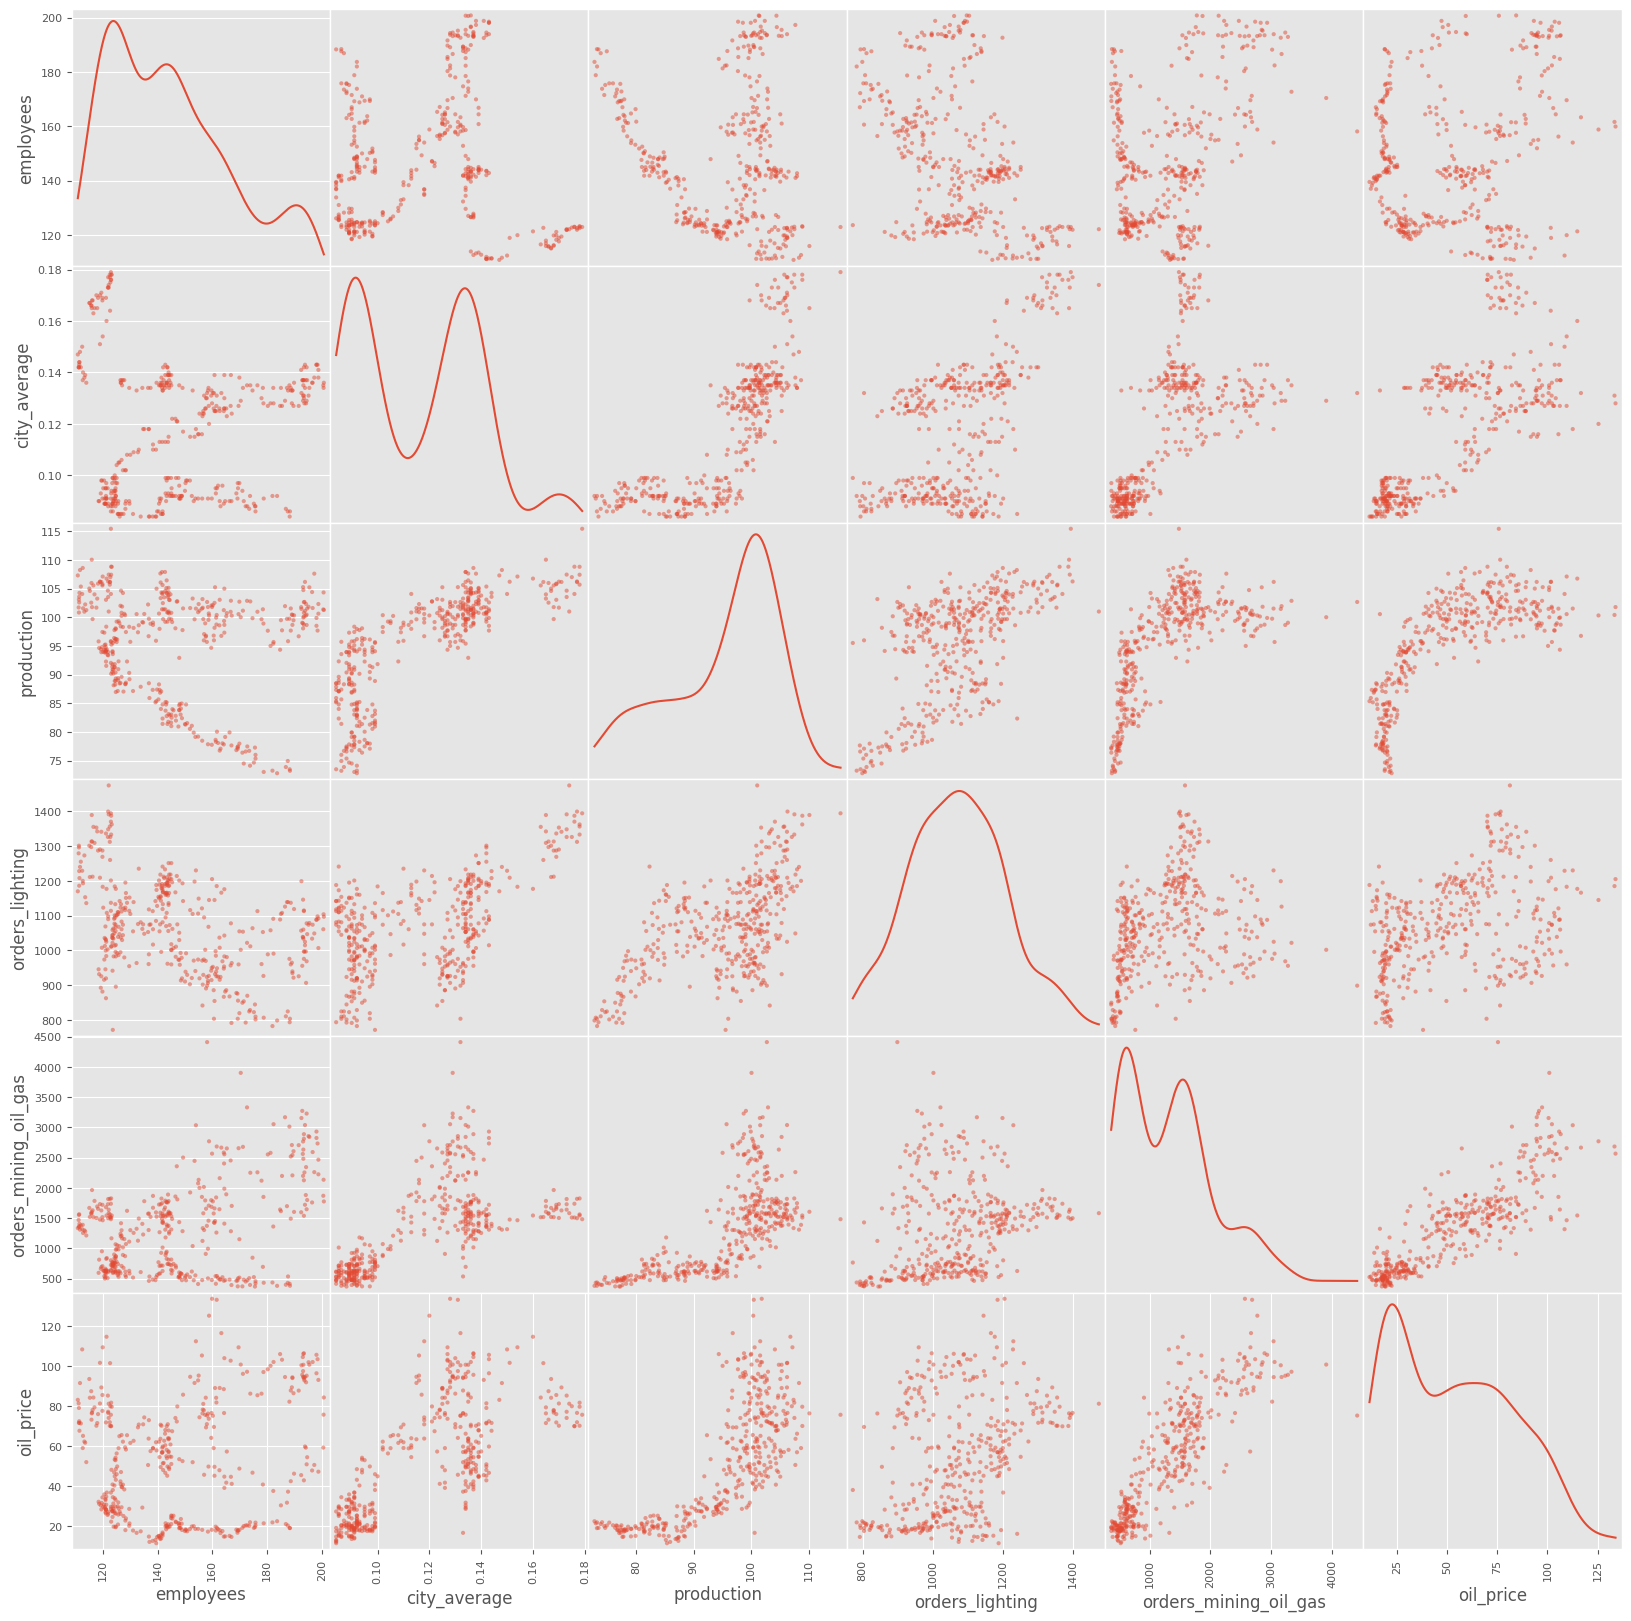

In [24]:
# Scatter plot matrix
pd.plotting.scatter_matrix(data, figsize=(20, 20), diagonal='kde')
plt.show()

Scatterplot Discussion:
The scatter plot shows the relationships among all combinations of two variables. Through visual inspection, there seem to be some pairs of variales that have a relationship. It is important to note that most of the relation pairs show heteroskedasticity.
- oil_price and production (non-linear, heteroskedasticity)
- oil_price and orders_mining_oil_gas (linear, heteroskedasticity)
- orders_mining_oil_gas and production (non-linear, heteroskedasticity)
- city_average and production (non-linear, heteroskedasticity)

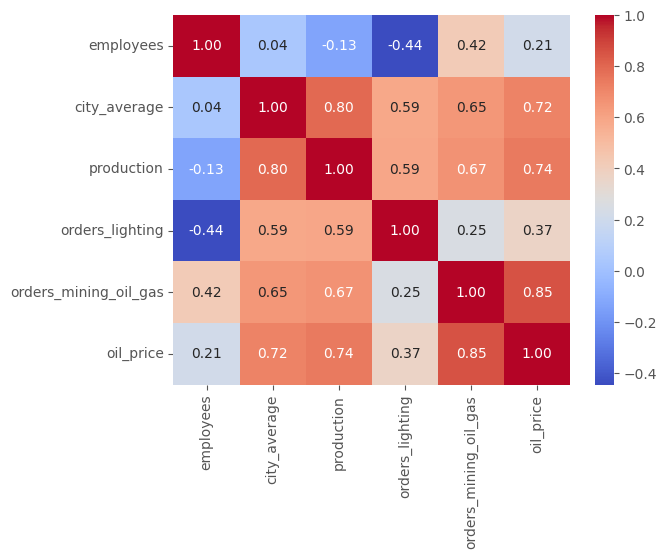

In [25]:
# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Correlation Matrix Discussion:<br>
The correlation matrix supports the findings above. Variable pairs that visually show a relationship have strong correlation.